# Adding income information to a synthetic population of households

In this example, we already have a synthetic population of households on Nantes city. This synthetic population was built using the French national Census of the population. For each household, serveral characteristics have been added:

- Ownership : owner or tenant of its accomodation
- Age : age of reference person
- Size : number of persons
- Family composition : composition (single person, couple with ou without children, etc)

The objectif is to add income information to each household. In order to reach this goal, we use another data source named Filosofi. More precisely, this data source gives information on the income distribution (deciles) for each city, per household characteristics.

Filosofi is an indicator set implemented by INSEE which is the French National Institute of Statistics. See [insee.fr](https://www.insee.fr/fr/metadonnees/source/serie/s1172) for more details.


## Data preparation

Read synthetic population which doesn't contain revenu information.

In [1]:
import pandas as pd

synth_pop = pd.read_csv("../tests/data/synpop_nantes.csv")

synth_pop.head()

,age,size,ownership,family_comp,sex
0,60_74,2_pers,Owner,Couple_without_child,F
1,60_74,2_pers,Owner,Couple_without_child,M
2,60_74,2_pers,Owner,Couple_without_child,M
3,0_29,1_pers,Tenant,Single_wom,F
4,60_74,2_pers,Owner,Couple_without_child,F


Read Filosofi data and format dataframe.

In [2]:
from bhepop2.tools import read_filosofi, filosofi_attributes

filosofi = read_filosofi(
    "../tests/data/FILO_DISP_COM.xls", "15", filosofi_attributes, ["44109"]
)

filosofi.head()

,commune_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,reference_median,attribute,modality
14824,44109,10303.478261,13336.071429,16023.846154,18631.333333,21262.666667,24188.000000,27774.444444,32620.000000,41308.000000,21262.666667,all,all
1974,44109,9794.000000,12961.000000,14914.000000,16865.000000,18687.000000,20763.000000,23357.000000,27069.000000,33514.000000,18687.000000,size,1_pers
2144,44109,12176.000000,15552.666667,18356.000000,20919.333333,23434.666667,26330.666667,30140.000000,35136.000000,44134.000000,23434.666667,size,2_pers
2144,44109,10583.500000,13655.555556,16489.000000,19145.000000,21893.333333,24890.555556,28440.000000,33432.222222,42079.444444,21893.333333,size,3_pers
2144,44109,10740.476190,14130.000000,17206.666667,20138.095238,22955.238095,26148.000000,29644.000000,34238.000000,42998.095238,22955.238095,size,4_pers


## Run algorithm

In [3]:
from bhepop2.enrichment.bhepop2 import Bhepop2Enrichment
from bhepop2.sources.marginal_distributions import QuantitativeMarginalDistributions

# Household modalities
MODALITIES = {
    "ownership": ["Owner", "Tenant"],
    "age": ["0_29", "30_39", "40_49", "50_59", "60_74", "75_or_more"],
    "size": ["1_pers", "2_pers", "3_pers", "4_pers", "5_pers_or_more"],
    "family_comp": [
        "Single_man",
        "Single_wom",
        "Couple_without_child",
        "Couple_with_child",
        "Single_parent",
        "complex_hh",
    ],
}

distributions = QuantitativeMarginalDistributions(
    filosofi, 
    attribute_selection=list(MODALITIES.keys()),
    abs_minimum=0, 
    relative_maximum=1.5, 
    delta_min=1000,
    name="Filosofi"
)

# Optimisation preparation
enrich_class = Bhepop2Enrichment(
    synth_pop,
    distributions,
    feature_name="income",
    seed=42,
)

# Assign data to synthetic population
pop = enrich_class.assign_features()
pop["income"] = round(pop["income"])

pop.head()

,age,size,ownership,family_comp,sex,income
0,60_74,2_pers,Owner,Couple_without_child,F,35616.0
1,60_74,2_pers,Owner,Couple_without_child,M,25144.0
2,60_74,2_pers,Owner,Couple_without_child,M,38942.0
3,0_29,1_pers,Tenant,Single_wom,F,27188.0
4,60_74,2_pers,Owner,Couple_without_child,F,28476.0


## Results analysis

### Data preparation

In [4]:
analysis = enrich_class.compare_with_source(enriched_population_name="Synthetic population")

### Some plots

In [5]:
from IPython.display import Image

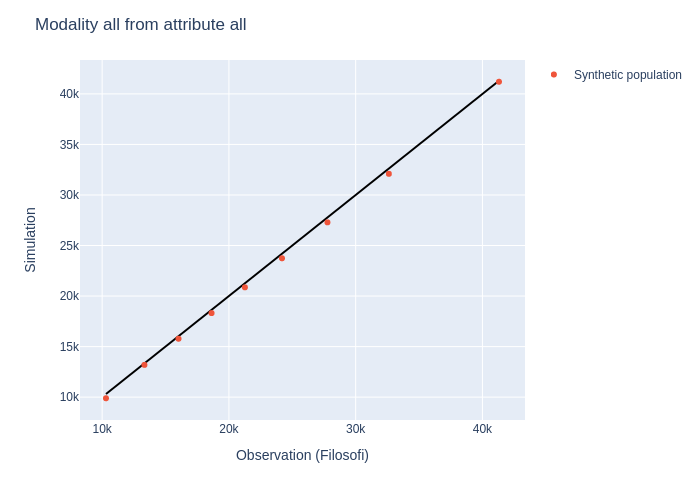

In [6]:
Image(analysis.plot_analysis_compare("all", "all").to_image())

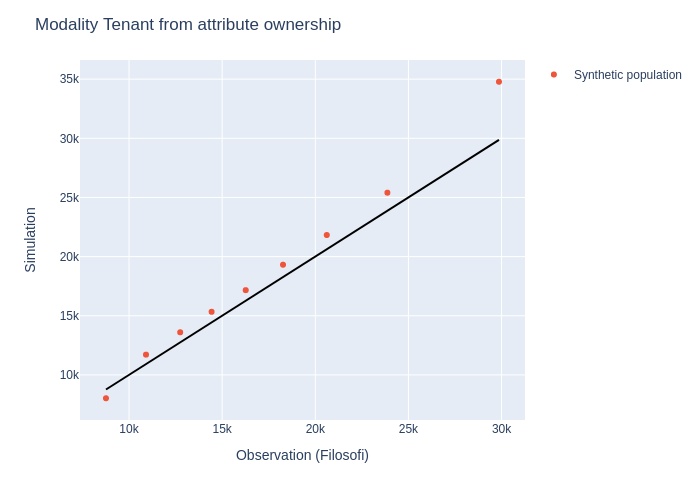

In [7]:
Image(analysis.plot_analysis_compare("ownership", "Tenant").to_image())


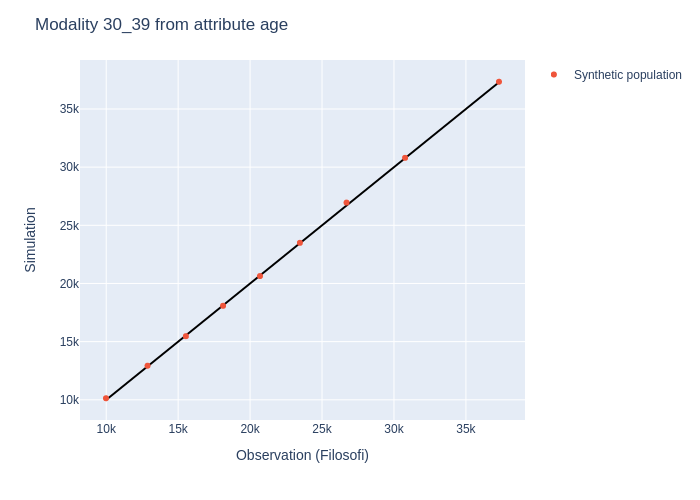

In [8]:
Image(analysis.plot_analysis_compare("age", "30_39").to_image())

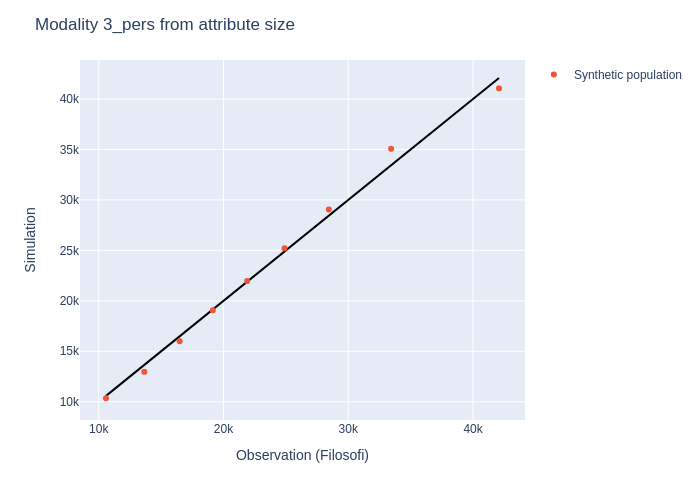

In [9]:
Image(analysis.plot_analysis_compare("size", "3_pers").to_image())

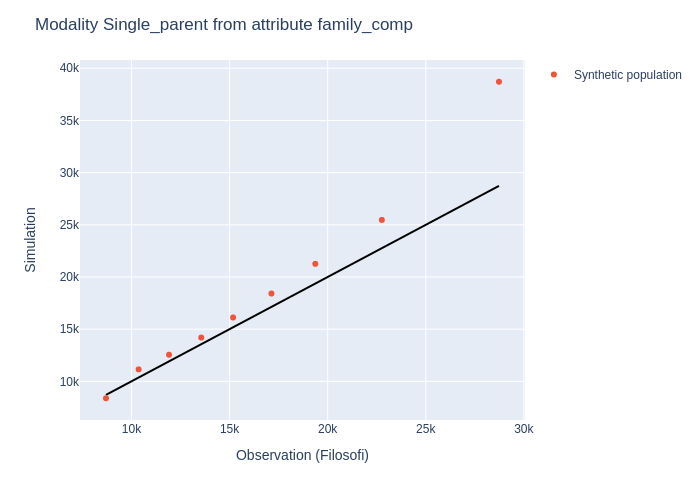

In [10]:
Image(analysis.plot_analysis_compare("family_comp", "Single_parent").to_image())